## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

---

### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [72]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [73]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [74]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


Yes, category Women

2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [75]:
from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

print(f"Chi-square statistic: {chi2_statistic}")
print(f"P-value: {chi2_p_value}")

Chi-square statistic: 36540.20270061387
P-value: 0.0


In [76]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
cramers = association(crosstab_result, method="cramer")
print(f"Cramér's V: {cramers}")

Cramér's V: 0.1222829439760564


The result is closer to 0 and this indicates that there is practically no association.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

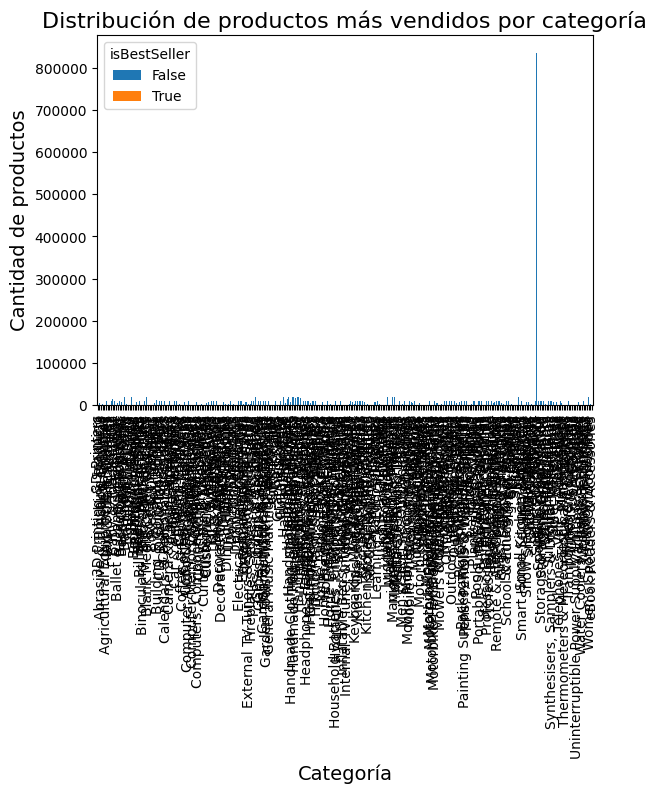

In [77]:
crosstab_result.plot(kind="bar", stacked=True)
plt.title('Distribución de productos más vendidos por categoría', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Cantidad de productos', fontsize=14)
plt.xticks(rotation=90)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

In [78]:

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
    
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Identify the outliers
outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
   


In [79]:
# Seleccionamos las 20 categorías con más productos
df_outliers = outliers['category'].value_counts().head(20).index

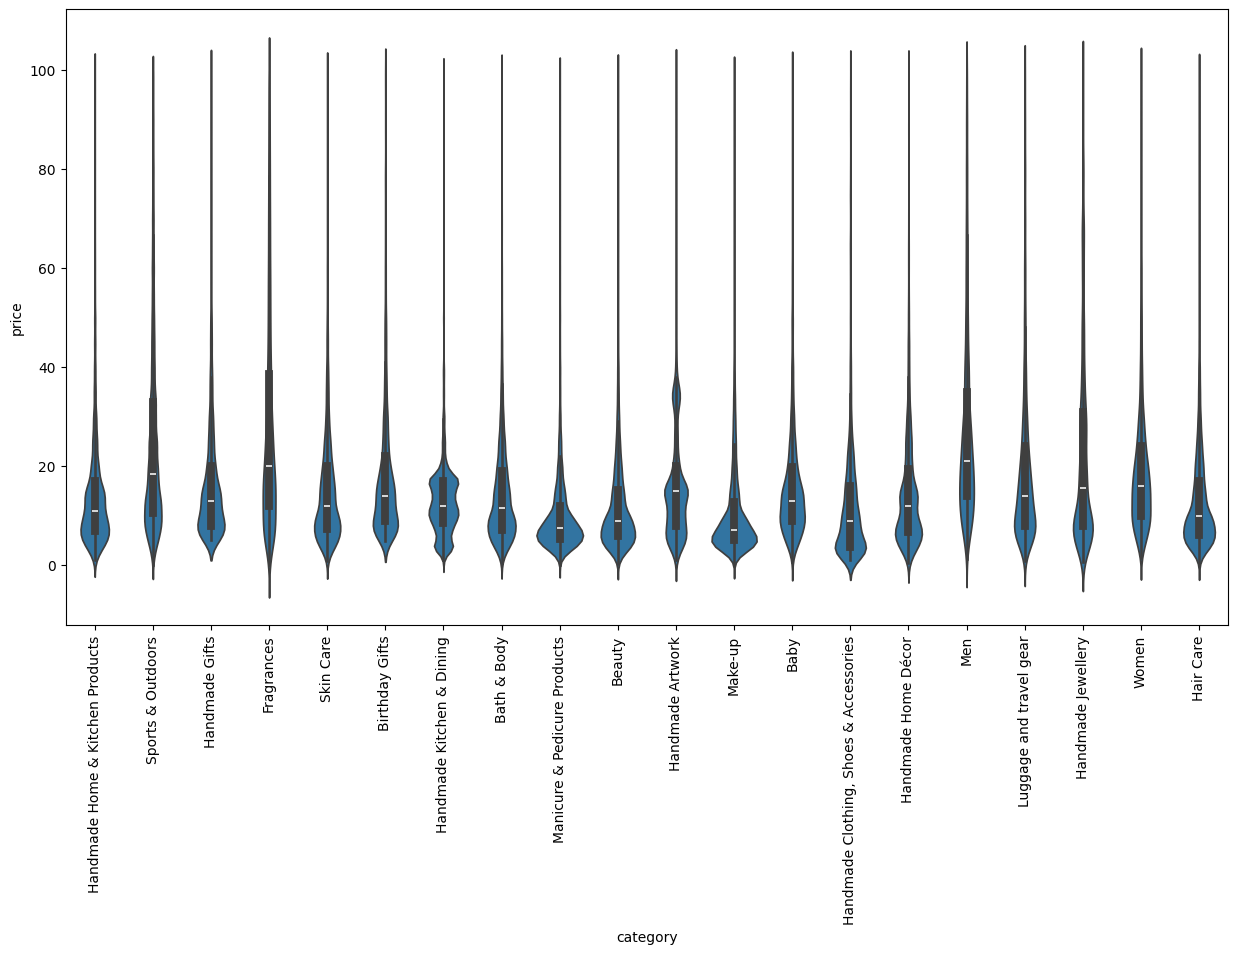

In [80]:
# Graficamos un violin plot para visualizar la distribución de precios
plt.figure(figsize=(15, 8))
sns.violinplot(data=outliers[outliers['category'].isin(df_outliers)], x='category', y='price')
plt.xticks(rotation=90)
plt.show()

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

C:\Users\Pilar\AppData\Local\Temp\ipykernel_18152\851881620.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_top_10.index, y=avg_price_top_10.values, palette="coolwarm")


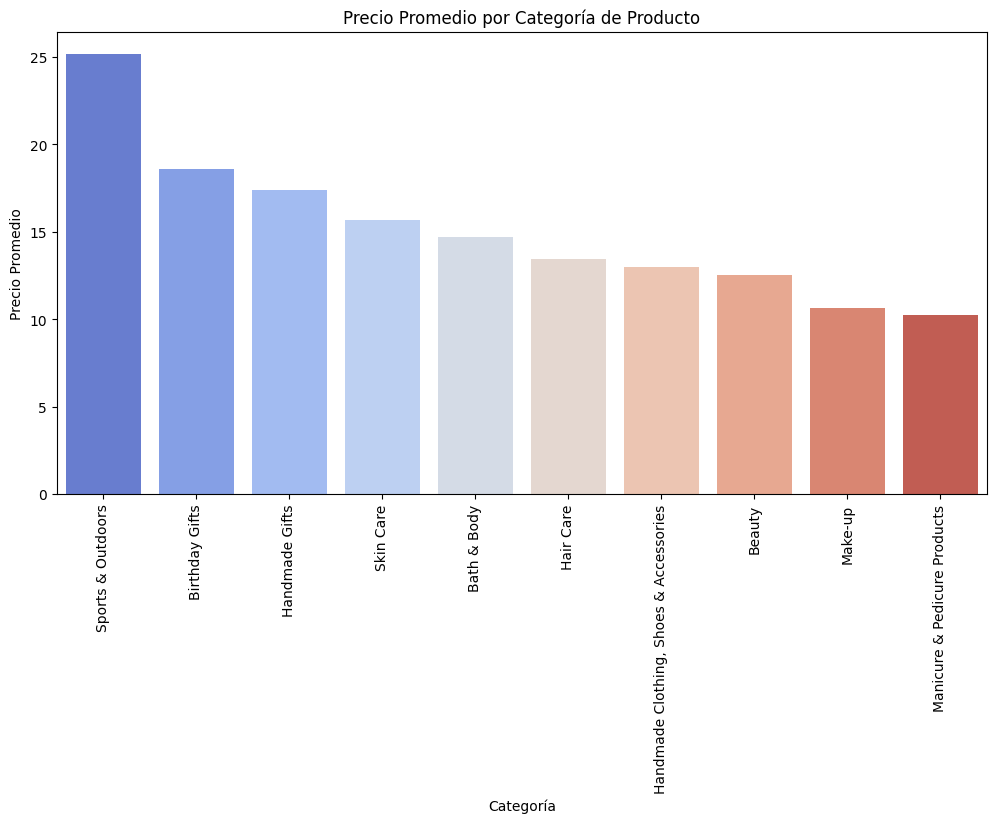

In [81]:
top_10_categories = outliers['category'].value_counts().head(10).index
avg_price_top_10 = outliers[outliers['category'].isin(top_10_categories)].groupby('category')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_top_10.index, y=avg_price_top_10.values, palette="coolwarm")
plt.title('Precio Promedio por Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)
plt.show()

In [82]:
highest_avg_price = outliers['category'].value_counts().head(1)
print(f"La categoría con la mayor media de precio es: {highest_avg_price}")

La categoría con la mayor media de precio es: category
Sports & Outdoors    694092
Name: count, dtype: int64


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

C:\Users\Pilar\AppData\Local\Temp\ipykernel_18152\3298190085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='stars', data=df[df['category'].isin(top_10_categories)], palette="coolwarm")


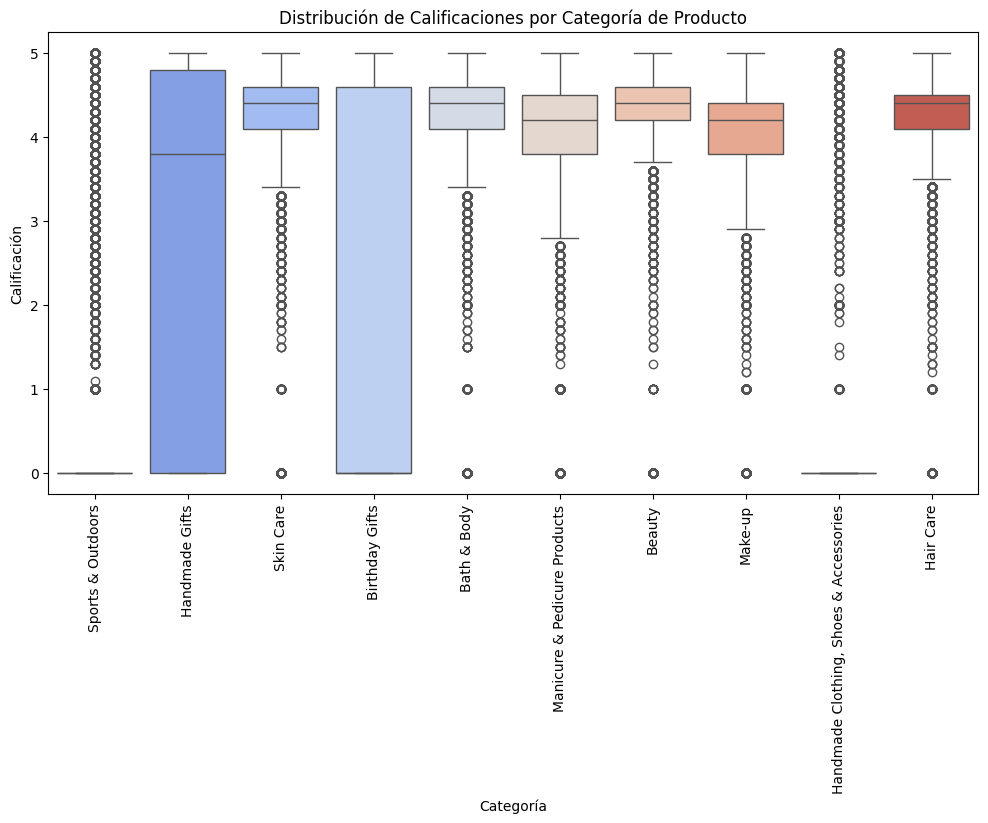

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=df[df['category'].isin(top_10_categories)], palette="coolwarm")
plt.title('Distribución de Calificaciones por Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Calificación')
plt.xticks(rotation=90)
plt.show()

In [84]:
top10_categories_no_outliers = outliers['category'].value_counts().head(10).index
top_10_data = outliers[outliers['category'].isin(top10_categories_no_outliers)]

In [85]:
median_category = top_10_data.groupby('category')['stars'].median().sort_values(ascending=False)
highest_median_category = median_category.idxmax()
highest_median_rating = median_category.max()

print(f"La categoría de productos con la mayor media es: '{highest_median_category}' con una media de: {highest_median_rating:.2f}")
     

La categoría de productos con la mayor media es: 'Bath & Body' con una media de: 4.40


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [86]:
correlation_pearson = outliers['price'].corr(outliers['stars'])
print(f"El coeficiente de correlación entre precio y rating es: {correlation_pearson:.2f}")

El coeficiente de correlación entre precio y rating es: -0.08


Are a lineal correlation

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

Text(0.5, 1.0, 'Relación entre Calificación y Precio de Productos')

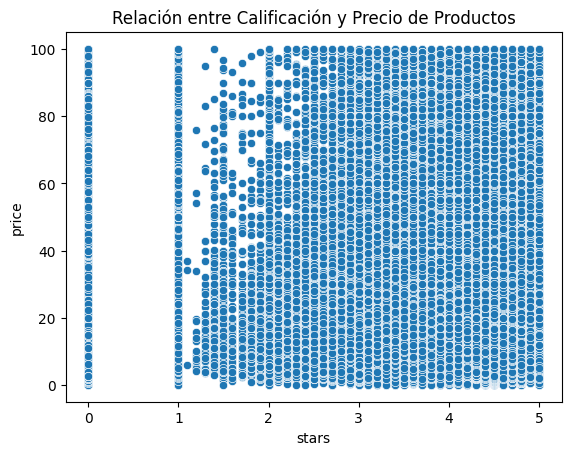

In [87]:
sns.scatterplot(data=outliers, x='stars', y='price')
plt.title('Relación entre Calificación y Precio de Productos')

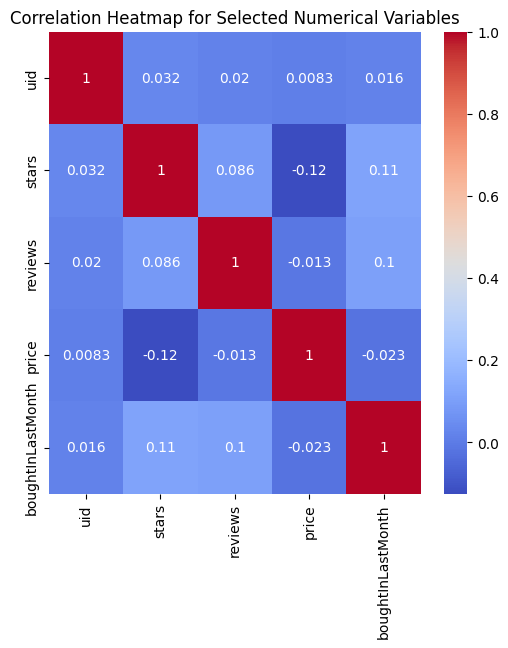

In [88]:
df_numerical = df.select_dtypes("number")
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

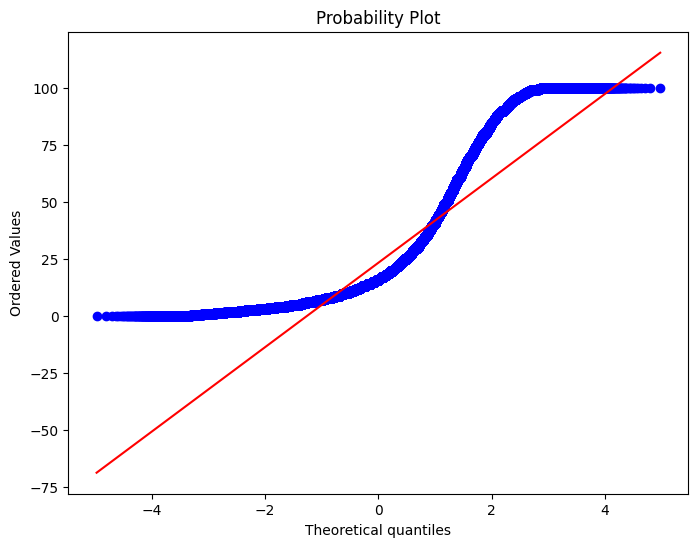

In [93]:
plt.figure(figsize=(8, 6)) 
stats.probplot(outliers['price'], dist="norm", plot=plt)
plt.show()